In [2]:
import configparser
import os
import sys
from time import sleep
from uuid import uuid4

import numpy as np

import GCode
import GRBL

# Laser Shading By adjusting focus on the Z-axis

# Code:

In [3]:
# Poplar 1x4". Cut
BlockHeight = 89.0  # [mm]
BlockLength = 2 * BlockHeight  # [mm]
BlockThickness = 19.0  # [mm]
print("{} x {} x {}".format(BlockHeight, BlockLength, BlockThickness))


89.0 x 178.0 x 19.0


In [4]:
config = configparser.ConfigParser()
config["GRBL"] = dict()
config["GRBL"]["port"] = "/dev/cnc_3018"
cnc = GRBL.GRBL(**config["GRBL"])

cnc.reset(home=True)

(3, ['', "Grbl 1.1f ['$' for help]", "[MSG:'$H'|'$X' to unlock]"])

In [8]:
if "Alarm" in cnc.status:
    cnc.home()

# Generate Program

Generate the G-code program that will test how the laser focus affects shading.

- Laser 'focused' at -14mm.
- Testing 17 positions between [-28, 0]
- Testing 3 different feed rates [100, 200, 300]
- Testing 5 different power settings between [100, 255]

In [9]:
# Define a gap between horizontal lines
vgap = 5  # [mm]
# Generate a list of horizontal line vertical coordinates
vs = np.arange(vgap, BlockHeight, vgap)

# Define a horizontal distance to test lazerin.
hgap = 10  # [mm]
hs = np.arange(0, BlockLength, hgap)

# Total travel range, starts at ztravel, ends at 0. "negative space"(?)
ztravel = -28
# Generate a number of z-axis test positions.
# Each z-height will have 10 mm marked at the given feed rate and power.

# Generate the full list of z-stops from the initial test.
zs_ = np.linspace(start=ztravel, stop=0, num=len(hs) - 1, endpoint=True)
# Generate a narrower list of z-stops where the laser worked.
zs = np.linspace(start=zs_[5], stop=zs_[13], num=len(hs) - 1, endpoint=True)
zs

# Laser powers to test.
powers = [255, 200, 150]

feeds = [50, 100, 150, 200, 300]

In [10]:
def init2(**kwargs):
    program = GCode.GCode(**kwargs)
    program.G0(F=500)
    program.G1(F=500)
    program.G21()  # Metric Units
    program.G90()  # Absolute positioning.
    return program

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

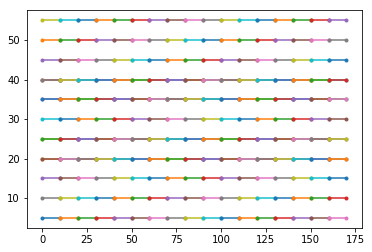

In [12]:
plt.figure()
ax1=plt.subplot(1,1,1)
programs = list()
for idx1, power in enumerate(powers): # [uint8 duty cycle]
    for idx2, feed in enumerate(feeds):  # [mm/min]
        v_idx = idx1 * len(powers) + idx2
        Y = vs[v_idx]
        for idx3, z in enumerate(zs):
            x0 = hs[idx3]
            xf = hs[idx3 + 1]
            ax1.plot(np.array([x0, xf]), np.array([Y, Y]), marker='.')
            
            program = init2(machine=cnc)
            program.G0(Z=z, Y=Y, X=x0)
            program.M4(S=power)
            program.G1(X=xf, Y=Y, Z=z, F=feed)
            program.M5()  # Laser. Off.
            programs.append(program)

In [15]:
cnc.home()

12

In [16]:
cnc.init()

True

In [17]:
for idx, program in enumerate(programs):
    print("{}: ".format(idx), end="")
    print(cnc.run(program))

0: 3.941985845565796
1: 13.55605149269104
2: 13.555519104003906
3: 13.556596994400024
4: 13.555415153503418
5: 13.554771900177002
6: 13.553548812866211
7: 13.555274963378906
8: 13.554189443588257
9: 13.554581880569458
10: 13.554708480834961
11: 13.554260015487671
12: 13.554081916809082
13: 13.554462909698486
14: 13.553756475448608
15: 13.554683446884155
16: 13.55438494682312
17: 27.375301122665405
18: 7.544731378555298
19: 7.5446977615356445
20: 7.545018196105957
21: 7.544924736022949
22: 7.544915676116943
23: 7.544929504394531
24: 7.543767213821411
25: 7.544123411178589
26: 7.545109748840332
27: 7.545728445053101
28: 7.544438600540161
29: 7.545063734054565
30: 7.5461106300354
31: 7.544776916503906
32: 7.544702529907227
33: 7.543821334838867
34: 21.366981983184814
35: 5.188392162322998
36: 5.741476058959961
37: 5.743166923522949
38: 5.741687297821045
39: 5.7436981201171875
40: 5.7412495613098145
41: 5.742617845535278
42: 5.740963459014893
43: 5.743375301361084
44: 5.742610454559326
45: